# Manual Segmentation for Comparative Analysis for German Credit dataset Random Forest Model

This notebook implements manual segmentation based on predictor variables (agents) using the same sum-based aggregation strategy.

**Approach:** Manually segment the cohort based on specific predictor variable criteria (duration > 30 AND checking_status_<0 == true), then apply the same aggregation method to both segments:
- **Subgroup S₁** (debtors credits over 30 years): Sum-based aggregation as in risk stratification
- **Subgroup S₂** (rest of cohort): Sum-based aggregation as in risk stratification

This demonstrates how the same aggregation method reveals different patterns when applied to different population subgroups defined by hypothesis-driven criteria.

In [1]:
import os
import sys
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cgt_perezsechi.visualization.graph import draw
from cgt_perezsechi.manipulation.norm import normalize_psi, normalize_r

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configure matplotlib for VS Code Jupyter
%matplotlib inline

In [3]:
# Load data
X = pd.read_pickle("../../../../data/credit/x_values.pkl")
num_clients = 500
X_shapley = X.iloc[:num_clients, :]
shap_values = np.load("../../../../data/credit/rf/shap_values.npy")
shap_interaction_values = np.load("../../../../data/credit/rf/shap_interaction_values.npy")

print(f"Loaded data: {num_clients} clients, {X_shapley.shape[1]} features")
print(f"SHAP values shape: {shap_values.shape}")
print(f"SHAP interaction values shape: {shap_interaction_values.shape}")

Loaded data: 500 clients, 48 features
SHAP values shape: (500, 48)
SHAP interaction values shape: (500, 48, 48)


## Manual Segmentation Based on Predictor Variables

We create a manual filter based on specific predictor variable criteria:
- **Subgroup of interest**: Debtors asking credits for more than 30 years (duration > 30 AND checking_status_<0 == true)
- **Rest of cohort**: All other individuals

In [4]:
# Create manual segmentation mask
# Subgroup: duration > 30 AND checking_status_<0 == true (debtors duration over 30)
duration_over_30 = X_shapley['duration'] > 30
is_debtor = X_shapley['checking_status_<0'] == True

subgroup_mask = duration_over_30 & is_debtor
rest_mask = ~subgroup_mask

# Display segmentation statistics
print("\n=== Manual Segmentation Statistics ===")
print(f"\nSubgroup (debtors duration over 30):")
print(f"  N = {subgroup_mask.sum()} clients ({subgroup_mask.sum()/num_clients*100:.1f}%)")
print(f"  Duration range: [{X_shapley[subgroup_mask]['duration'].min():.0f}, {X_shapley[subgroup_mask]['duration'].max():.0f}]")
print(f"  Duration mean: {X_shapley[subgroup_mask]['duration'].mean():.1f}")

print(f"\nRest of cohort:")
print(f"  N = {rest_mask.sum()} clients ({rest_mask.sum()/num_clients*100:.1f}%)")
print(f"  Duration range: [{X_shapley[rest_mask]['duration'].min():.0f}, {X_shapley[rest_mask]['duration'].max():.0f}]")
print(f"  Duration mean: {X_shapley[rest_mask]['duration'].mean():.1f}")
print(f"  Debtors: {X_shapley[rest_mask]['checking_status_<0'].sum()} ({X_shapley[rest_mask]['checking_status_<0'].sum()/rest_mask.sum()*100:.1f}%)")


=== Manual Segmentation Statistics ===

Subgroup (debtors duration over 30):
  N = 22 clients (4.4%)
  Duration range: [33, 60]
  Duration mean: 41.3

Rest of cohort:
  N = 478 clients (95.6%)
  Duration range: [4, 60]
  Duration mean: 19.3
  Debtors: 106.0 (22.2%)


## Build Networks with Sum-Based Aggregation

We apply the same sum-based aggregation strategy to both segments, as defined in equations eq:manual_s1_node and eq:manual_s2_node:

For each segment, we compute:
- **Node weights**: N*ᵢ = Σₜ∈S Shᵢ(Δᵗ) / Σᵤ Σₜ∈S |Shᵤ(Δᵗ)|
- **Edge weights**: E*ᵢⱼ = Σₜ∈S Iᵢⱼ(Δᵗ) / Σᵥ Σᵤ>ᵥ Σₜ∈S |Iᵤᵥ(Δᵗ)|

where S is the set of clients in the segment (S₁ for males over 50, S₂ for the rest).

In [5]:
def build_network_sum_based(client_mask, shap_values, shap_interaction_values, X_shapley):
    """
    Build psi and r matrices for a specific client segment using sum-based aggregation.
    
    This follows the same approach as risk stratification:
    - Node weights: N*ᵢ = Σₜ∈S Shᵢ(Δᵗ) / Σᵤ Σₜ∈S |Shᵤ(Δᵗ)|
    - Edge weights: E*ᵢⱼ = Σₜ∈S Iᵢⱼ(Δᵗ) / Σᵥ Σᵤ>ᵥ Σₜ∈S |Iᵤᵥ(Δᵗ)|
    
    Parameters:
    -----------
    client_mask : boolean array
        Mask for selecting clients in this segment
    shap_values : numpy array
        SHAP values array (all clients)
    shap_interaction_values : numpy array
        SHAP interaction values array (all clients)
    X_shapley : DataFrame
        Feature dataframe
    
    Returns:
    --------
    psi_1, r_1, psi_2, r_2 : DataFrames
        Non-normalized and normalized node/edge weights
    """
    # Filter SHAP values for this segment
    segment_shap = shap_values[client_mask]
    segment_interaction = shap_interaction_values[client_mask]
    
    # Calculate psi_1 (node weights)
    # Numerator: sum over clients for each feature
    # Denominator: sum of absolute values over all clients and all features
    sum_shap = np.sum(np.abs(segment_shap), axis=(0, 1))
    psi_1 = pd.DataFrame()
    psi_1['value'] = np.sum(segment_shap, axis=0) / sum_shap
    psi_1.set_index(X_shapley.columns, inplace=True)
    
    # Calculate r_1 (edge weights) - use only lower triangular matrix for denominator
    n_clients_segment = segment_interaction.shape[0]
    n_variables = segment_interaction.shape[1]
    
    # Clean NaN values
    filtered_interaction = np.nan_to_num(segment_interaction.copy())
    
    # Create lower triangular mask (u > v means row > col, excluding diagonal)
    lower_tri_mask = np.tril(np.ones((n_variables, n_variables), dtype=bool), k=-1)
    
    # Calculate denominator: sum of absolute values of lower triangular elements only
    # sum_v sum_{u>v} sum_t |I_uv(Delta^t)|
    sum_interaction_lower = 0.0
    for client_idx in range(n_clients_segment):
        sum_interaction_lower += np.sum(np.abs(filtered_interaction[client_idx][lower_tri_mask]))
    
    # Calculate numerator: sum over clients for each (i,j) pair
    # sum_t I_ij(Delta^t)
    cumulative_interaction = np.sum(filtered_interaction, axis=0)
    
    # Zero out diagonal (remove self-interactions)
    np.fill_diagonal(cumulative_interaction, 0)
    
    # Calculate edge weights: E*_ij = numerator / denominator
    r_1 = pd.DataFrame(cumulative_interaction / sum_interaction_lower)
    r_1.rename(columns=dict(list(zip(r_1.columns, X_shapley.columns))), inplace=True)
    r_1.set_index(X_shapley.columns, inplace=True)
    
    # Normalize for visualization
    psi_2 = normalize_psi(psi_1)
    r_2 = normalize_r(r_1)
    
    return psi_1, r_1, psi_2, r_2

In [6]:
# Clean SHAP values (handle NaN)
shap_values_clean = np.nan_to_num(shap_values)

# Build network for subgroup S₁ (debtors duration over 30)
print("Building network for subgroup S₁ (debtors duration over 30)...")
subgroup_psi_1, subgroup_r_1, subgroup_psi_2, subgroup_r_2 = build_network_sum_based(
    subgroup_mask, shap_values_clean, shap_interaction_values, X_shapley
)
print("  Done.")

# Build network for rest of cohort S₂
print("\nBuilding network for rest of cohort S₂...")
rest_psi_1, rest_r_1, rest_psi_2, rest_r_2 = build_network_sum_based(
    rest_mask, shap_values_clean, shap_interaction_values, X_shapley
)
print("  Done.")

Building network for subgroup S₁ (debtors duration over 30)...
  Done.

Building network for rest of cohort S₂...
  Done.


## Visualization Setup

In [16]:
shap_cmap = shap.plots.colors.red_blue
positive_color = shap_cmap(0.0)[:3]
negative_color = shap_cmap(1.0)[:3]

positive_alpha = 0.05
negative_alpha = 0.05
positive_beta = 0
negative_beta = 0

## Network Visualization: Subgroup S₁ (Males over 50)

This network shows the aggregated SHAP influence for males over 50 years old using sum-based aggregation.

Network for Debtors asking credits with duration over 30 (N=22)

Saving the graph to ..\..\..\..\result\credit_rf_manual_subgroup_network.jpg


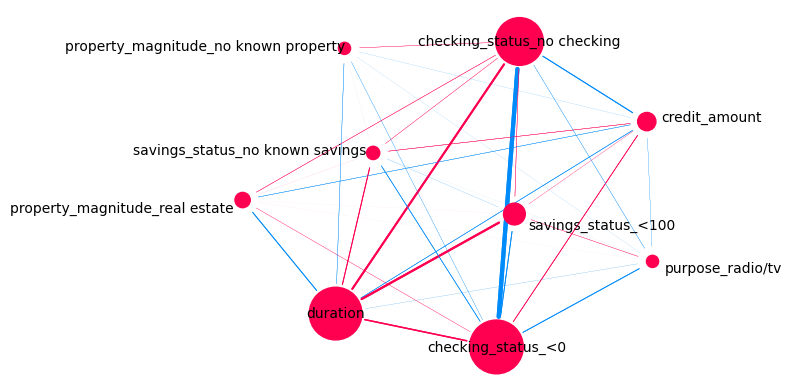

In [21]:
print(f"Network for Debtors asking credits with duration over 30 (N={subgroup_mask.sum()})")
print()

draw(
    psi=subgroup_psi_2,
    r=subgroup_r_2,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
    label_color='black',
    label_weight='normal',
    output_path=os.path.join('..', '..', '..','..', 'result', 'credit_rf_manual_subgroup_network.jpg')
)

## Network Visualization: Rest of Cohort S₂

This network shows the aggregated SHAP influence for the rest of the cohort using the same sum-based aggregation method.

Network for Rest of Cohort (N=478)

Saving the graph to ..\..\..\..\result\credit_rf_manual_rest_network.jpg


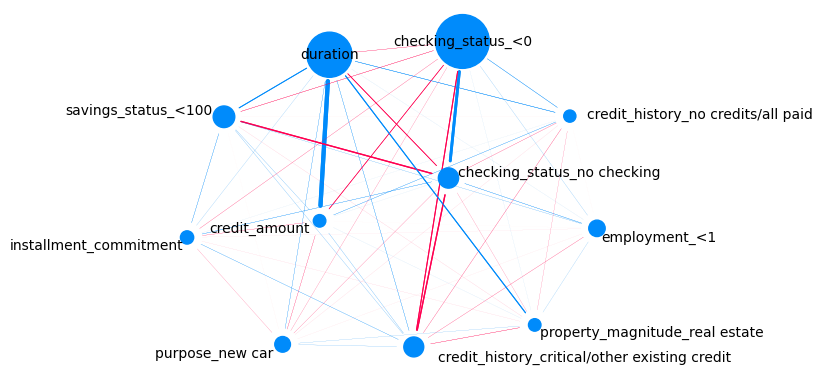

In [22]:
print(f"Network for Rest of Cohort (N={rest_mask.sum()})")
print()

draw(
    psi=rest_psi_2,
    r=rest_r_2,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
    label_color='black',
    label_weight='normal',
    output_path=os.path.join('..', '..', '..','..', 'result', 'credit_rf_manual_rest_network.jpg')
)